In [1]:
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline


try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    if np.__version__ != '1.23.4':
        print('installing compatible numpy')
        %pip install -q numpy==1.23.4
    %pip install -q dynamax[notebooks]
    import dynamax
    
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

from functools import partial

import numpy as np
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from dynamax.hidden_markov_model import GaussianHMM
from dynamax.utils.plotting import CMAP, COLORS, white_to_color_cmap
from dynamax.utils.utils import find_permutation

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
def generate_HMM(true_num_states, observations_dim, num_timesteps, num_train_batches, num_test_batches):


    hmm = GaussianHMM(true_num_states, observations_dim)

    # Set the initial state distribution
    initial_probs = jnp.ones(true_num_states) / true_num_states

    # Set the transition matrix
    transition_matrix = 0.80 * jnp.eye(true_num_states) \
        + 0.15 * jnp.roll(jnp.eye(true_num_states), 1, axis=1) \
        + 0.05 / true_num_states
    
    
    # Generating the sample data from make_blobs
    # This particular setting has one distinct cluster and 3 clusters placed close
    # together.
    rand_std = np.random.uniform(0.3, 1.5, 3)

    X, y = make_blobs(n_samples=num_timesteps, 
                      n_features=observations_dim,
                      centers=true_num_states, 
                      cluster_std=rand_std, random_state = 0)
    


    # Set the emission probabilities - mean and covariances
    emission_means = jnp.array([np.nanmean(X[y == c_no], axis = 0) for c_no in range(len(np.unique(y)))])

    emission_covs = jnp.array([np.cov(X[y == c_no].T) for c_no in range(len(np.unique(y)))])


    # Construct the HMM - this will be our ground truth 
    true_params, _ = hmm.initialize(initial_probs=initial_probs,
                                    transition_matrix=transition_matrix,
                                    emission_means=emission_means,
                                    emission_covariances=emission_covs)
    
    return hmm, true_params



    
def cross_validate_model(model, key, ax, num_iters=100):
    
    # Initialize the parameters using K-Means on the full training set
    params, props = model.initialize(key=key, emissions=train_observations,method = 'kmeans')
    
    # Split the training data into folds.
    folds = jnp.stack([
        jnp.concatenate([train_observations[:i], train_observations[i+1:]])
        for i in range(num_train_batches)
    ])
    
    def _fit_fold(y_train, y_val, k, ax):
        # Funtion to fit the HMM
        fit_params, train_lps = model.fit_em(params, props, y_train, 
                                             num_iters=num_iters, verbose=False)
        if k == 0:
            states = model.most_likely_states(fit_params, y_val)
            means = fit_params.emissions.means
            ax.plot(y_val[:, 0],y_val[:, 1], color = 'silver', lw = 0.5,alpha = 0.3)
            ax.scatter(y_val[:, 0], y_val[:, 1], c = states, s = 1, alpha = 0.6 )
            ax.set_aspect(1.0)

        means = fit_params.emissions.means
        eig, _ = np.linalg.eigh(np.cov(means))

        return model.marginal_log_prob(fit_params, y_val), np.nanmax(eig)
    
    val_lls = np.zeros(num_train_batches)
    eigs = np.zeros(num_train_batches)
    for k in range(num_train_batches): 
        y_val = train_observations[k]
        y_train = train_observations[list(set(np.arange(num_train_batches))  - set([k]))]
        # print(f.shape, train_observations.shape)
        val_lls[k], eigs[k] = _fit_fold(y_train, y_val, k, ax)
        
    return val_lls.mean(), val_lls, eigs.mean()



def min_max(x): 
    return (x - np.min(x))/(np.max(x) - np.min(x))

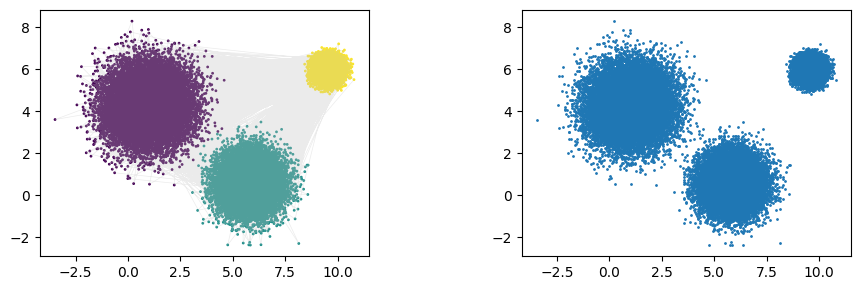

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


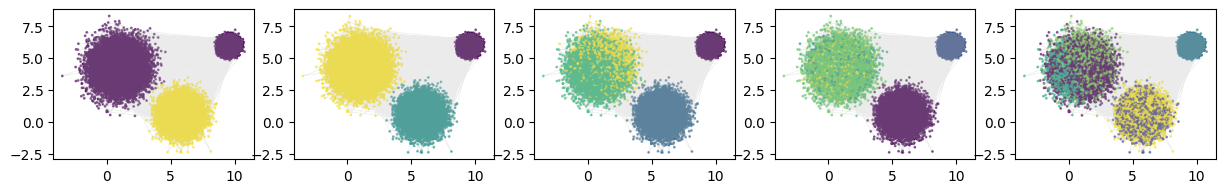

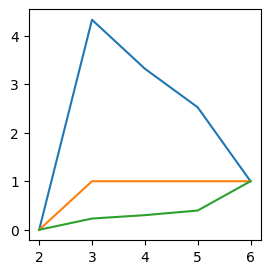

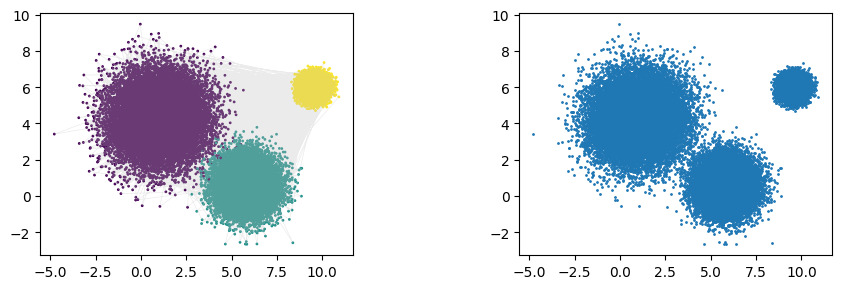

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


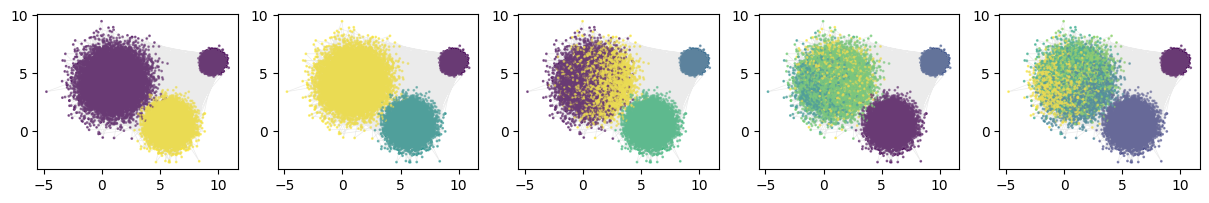

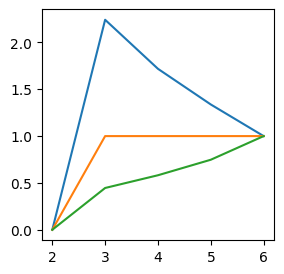

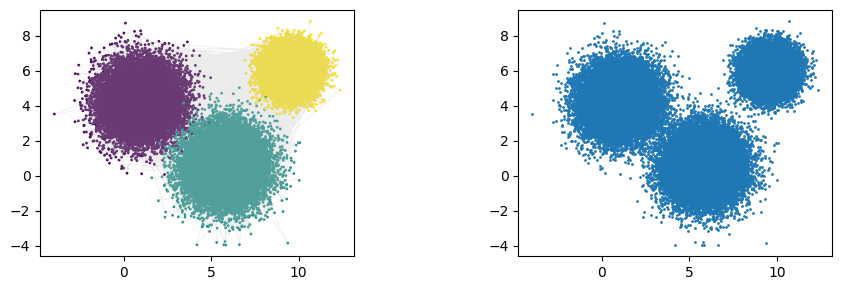

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


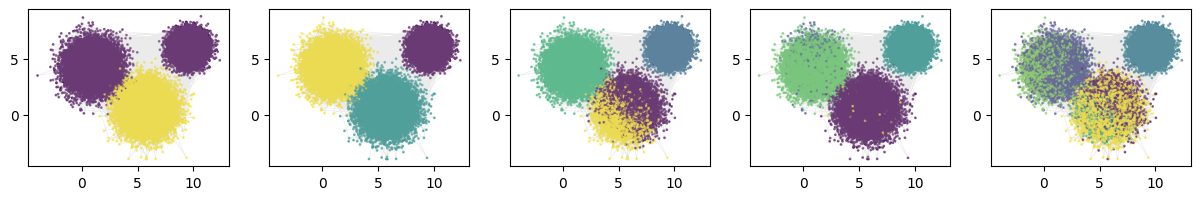

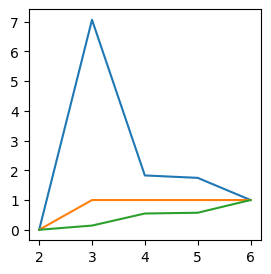

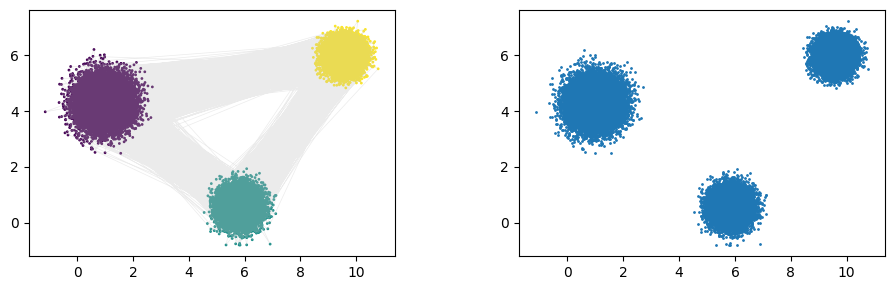

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


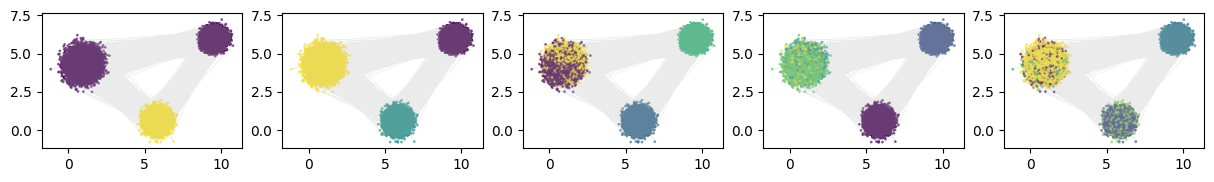

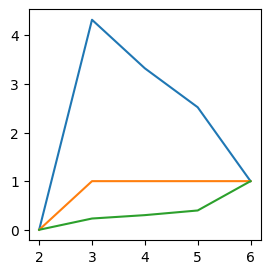

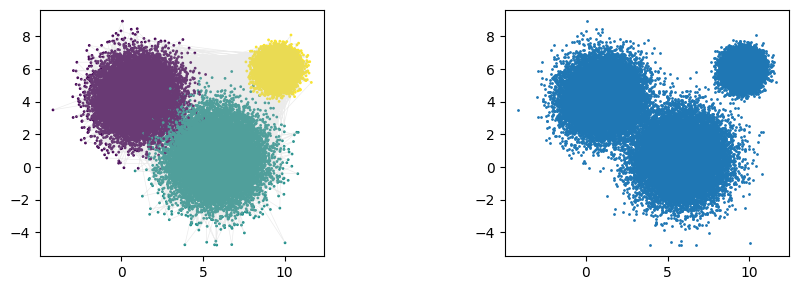

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


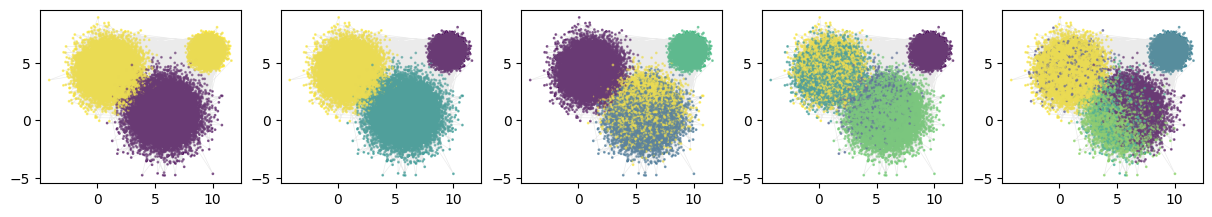

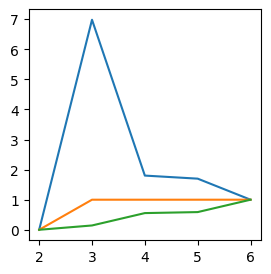

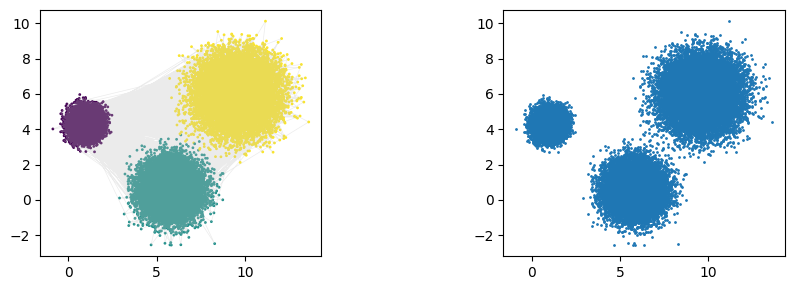

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


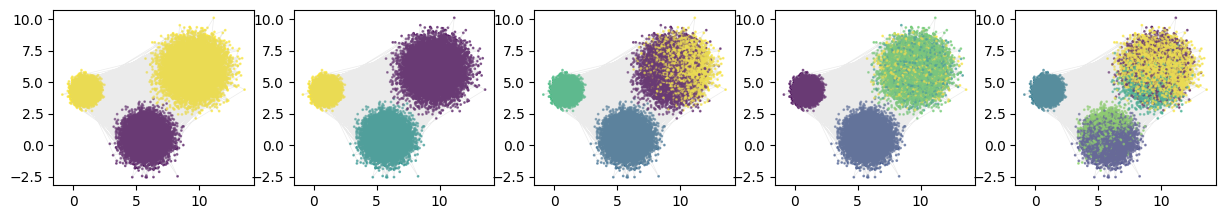

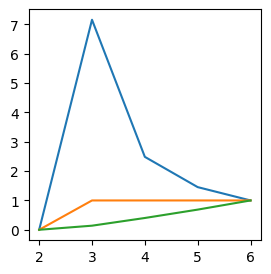

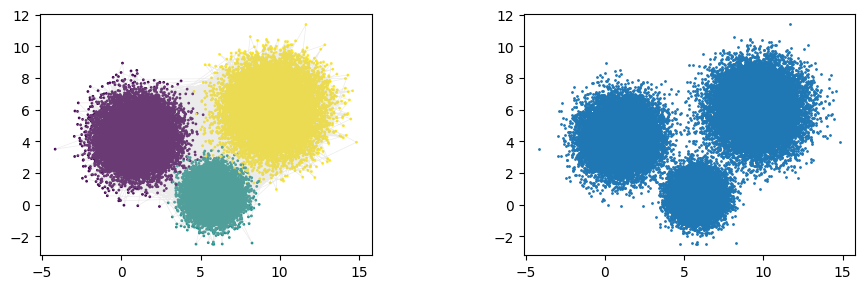

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


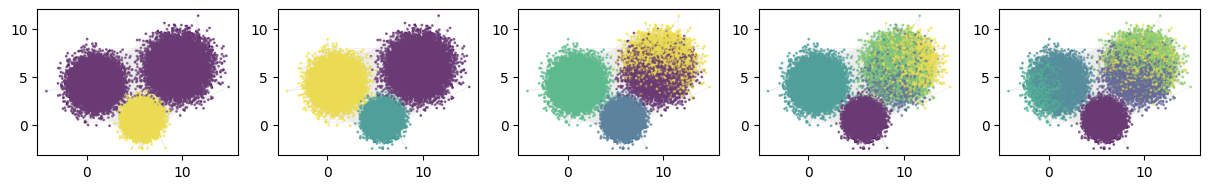

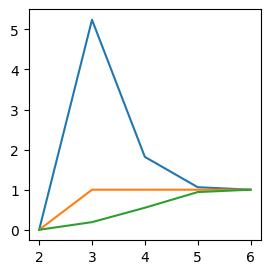

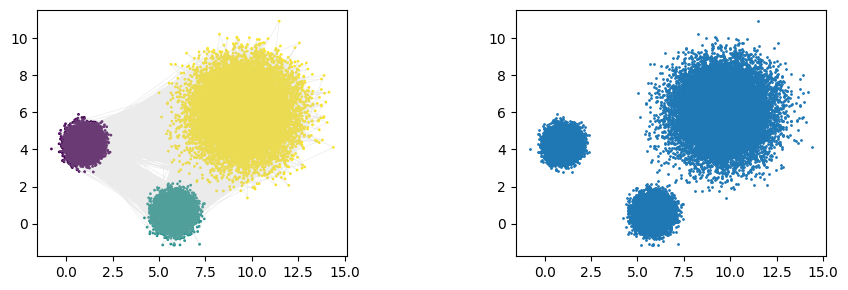

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


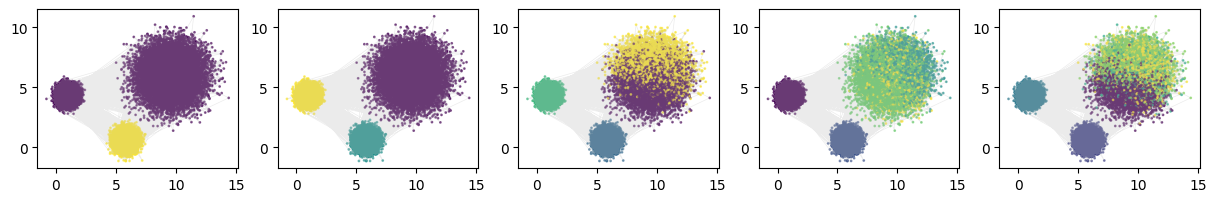

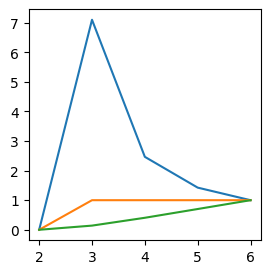

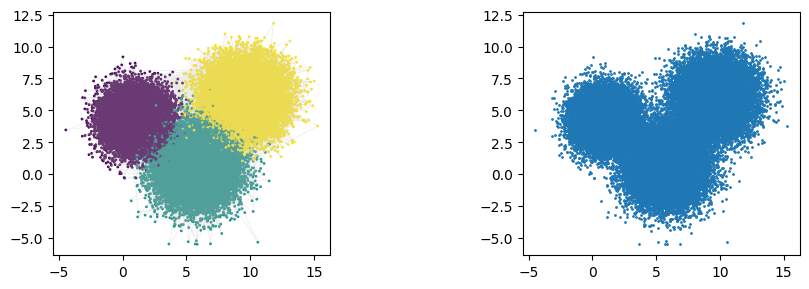

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


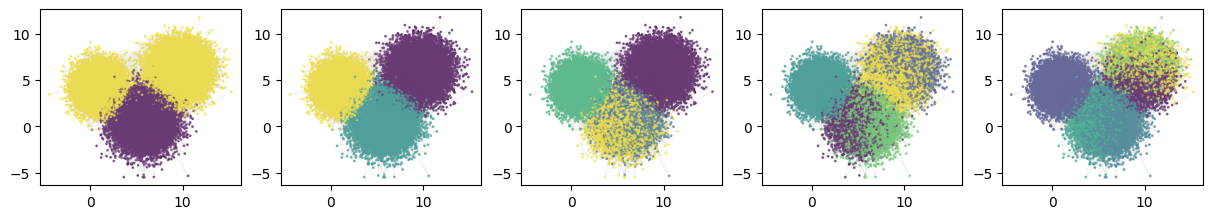

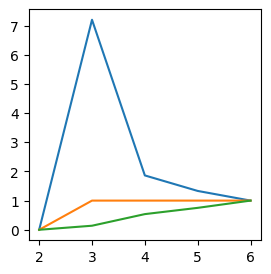

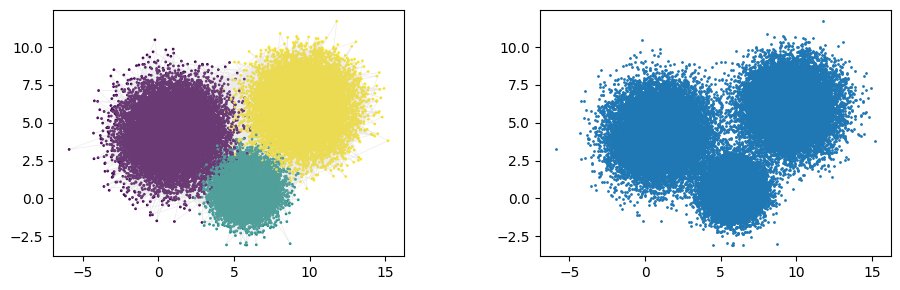

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


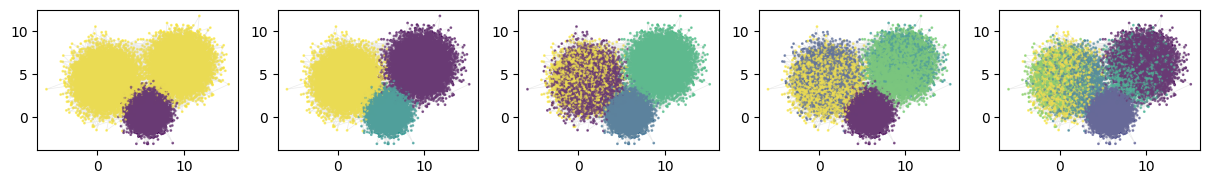

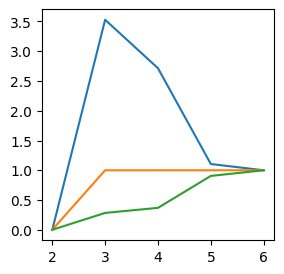

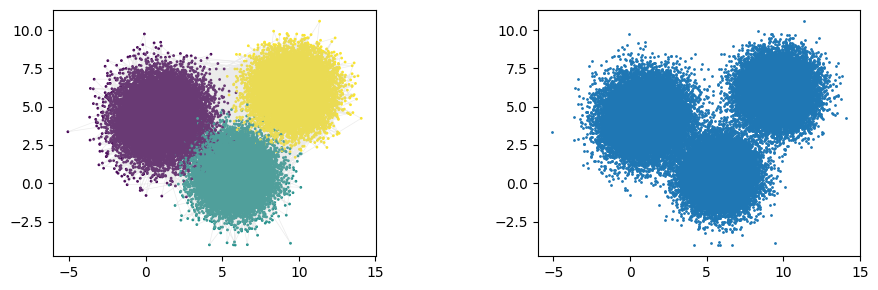

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


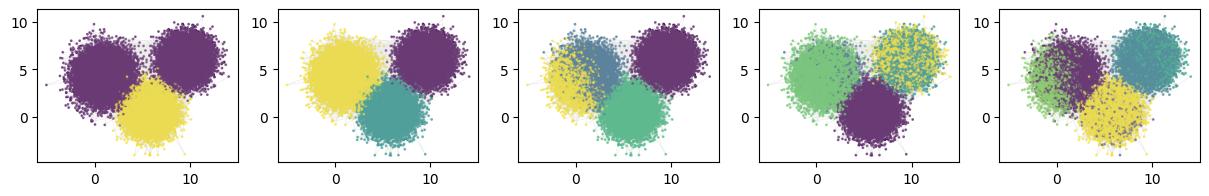

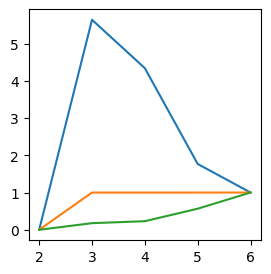

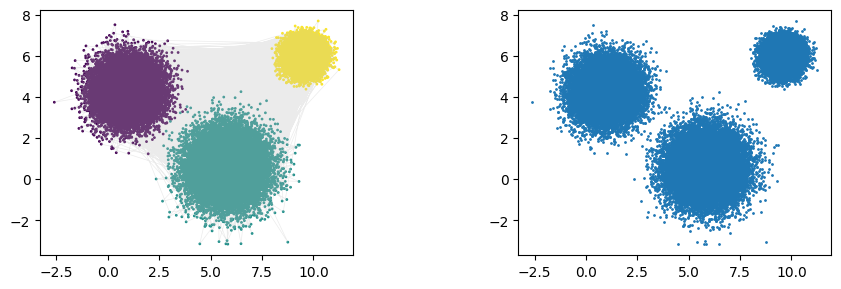

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


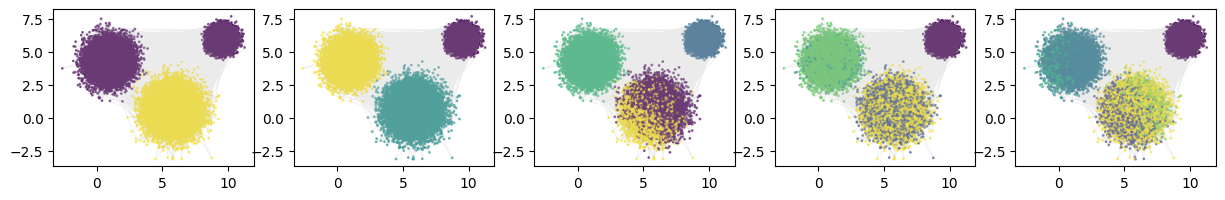

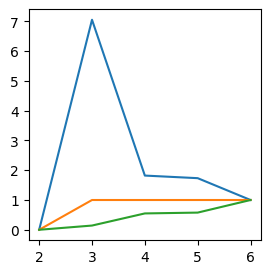

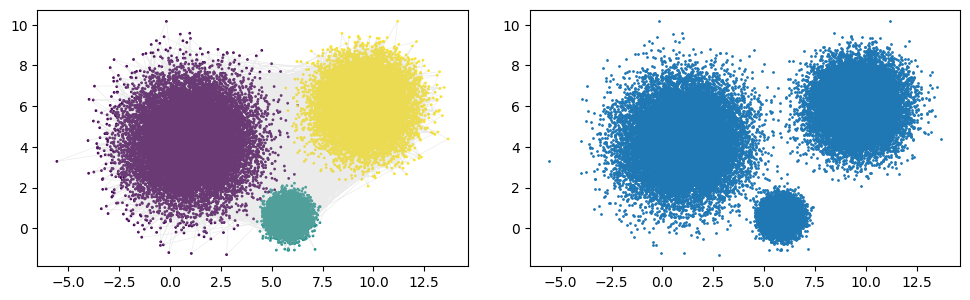

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


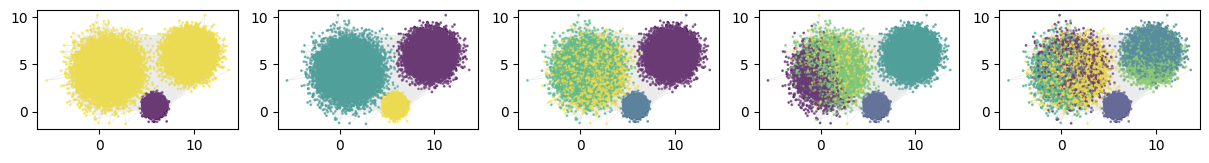

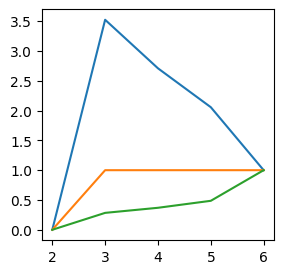

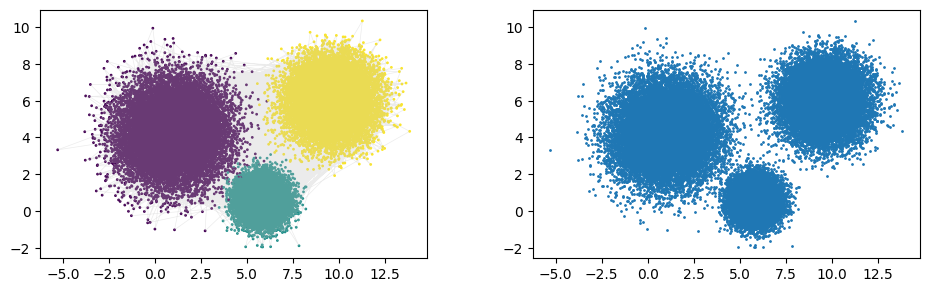

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


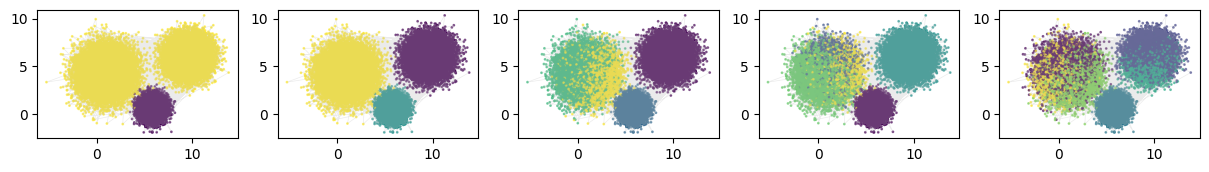

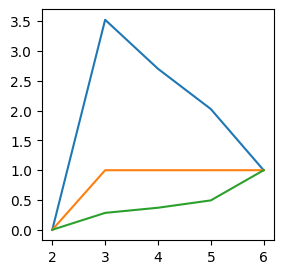

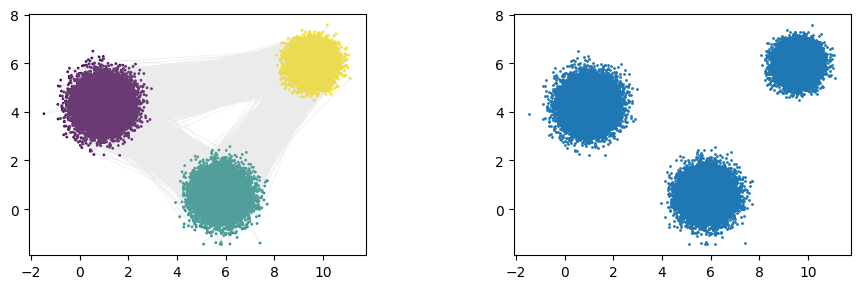

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


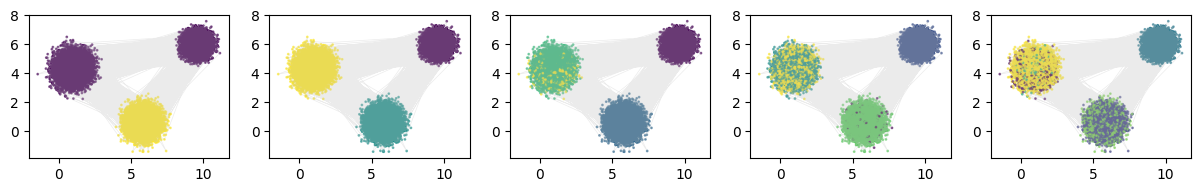

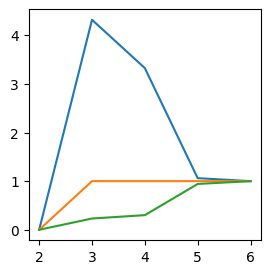

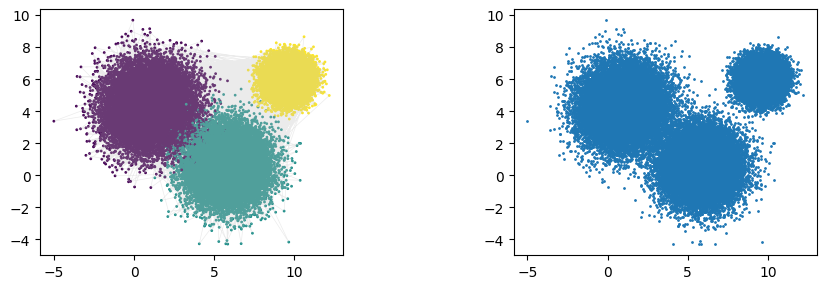

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


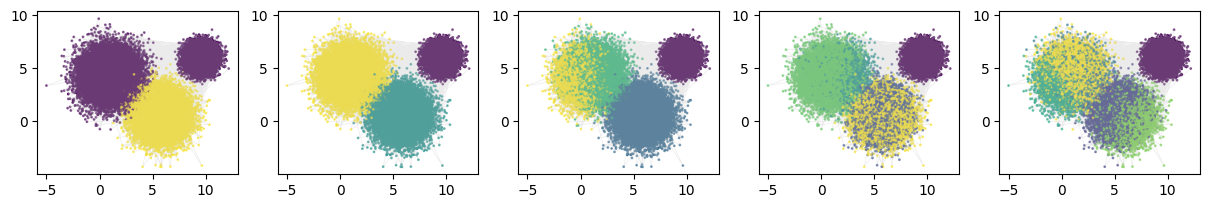

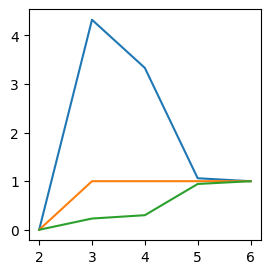

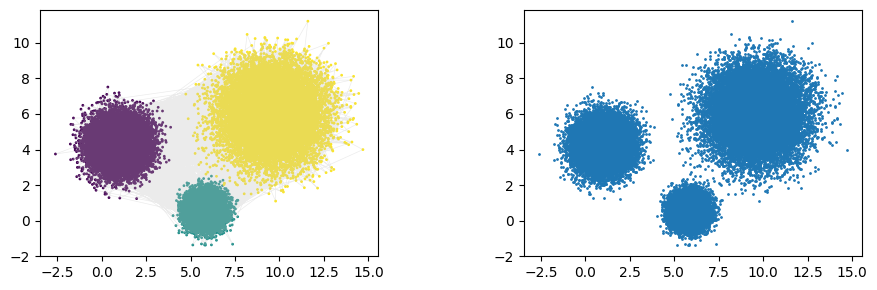

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


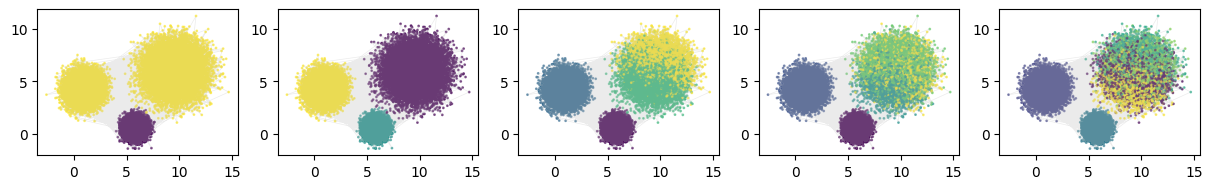

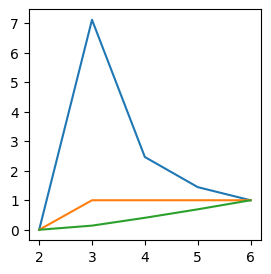

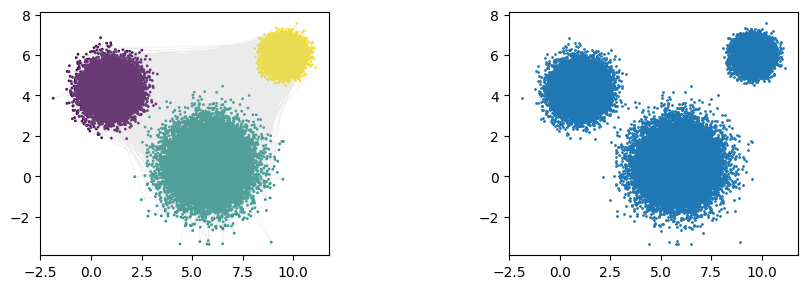

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


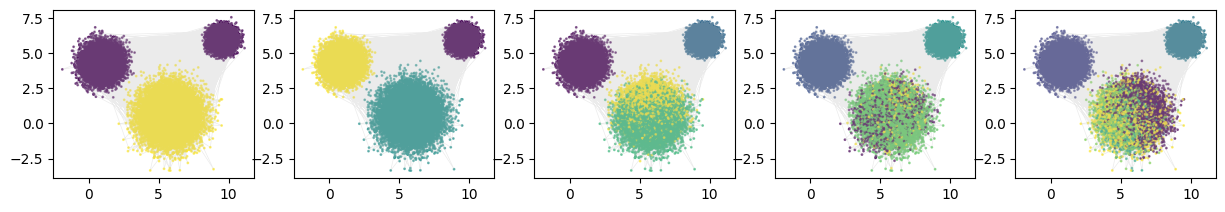

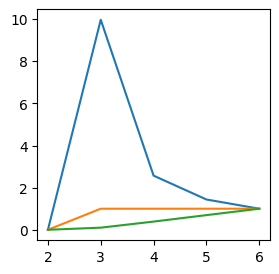

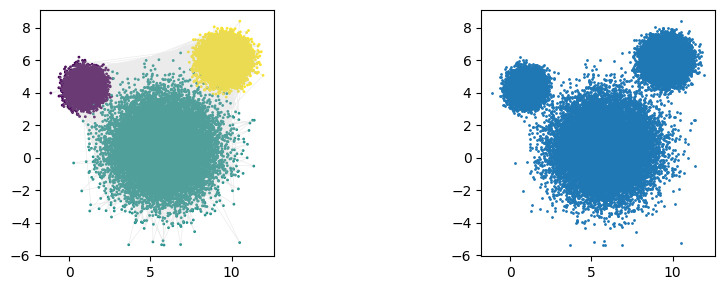

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


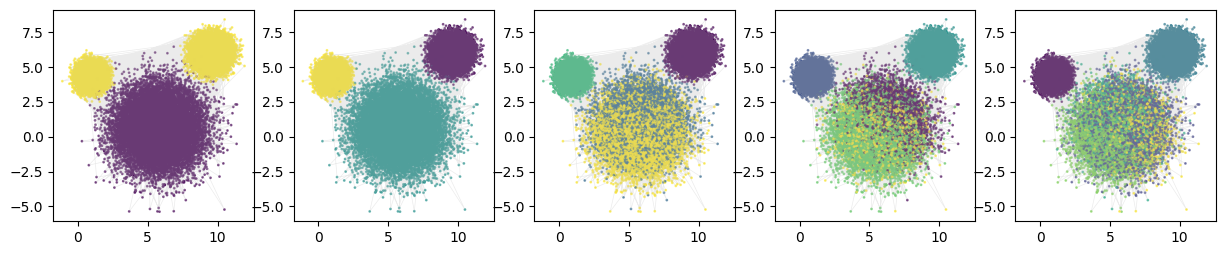

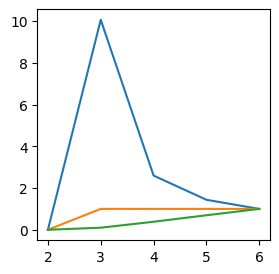

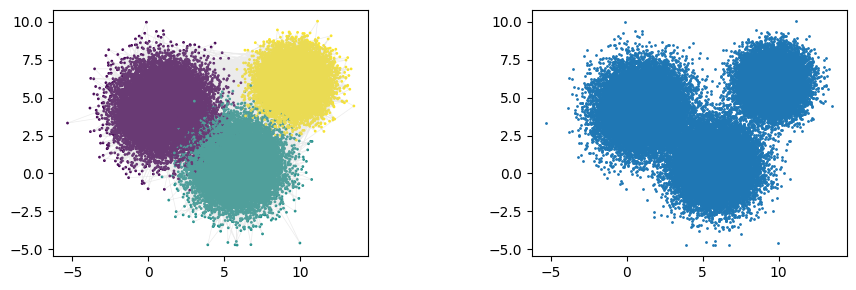

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


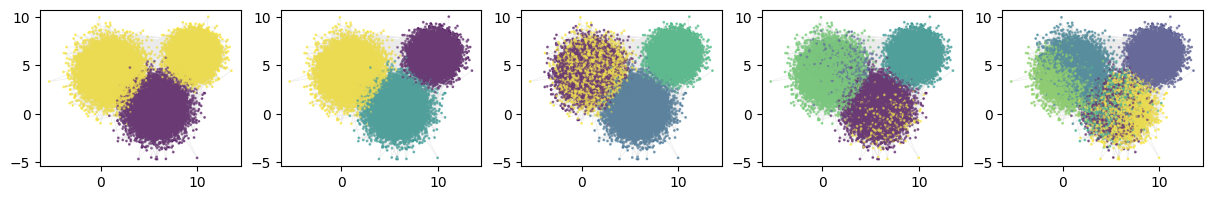

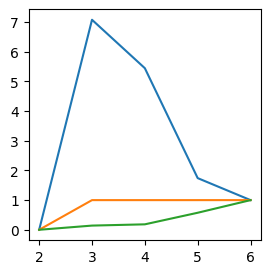

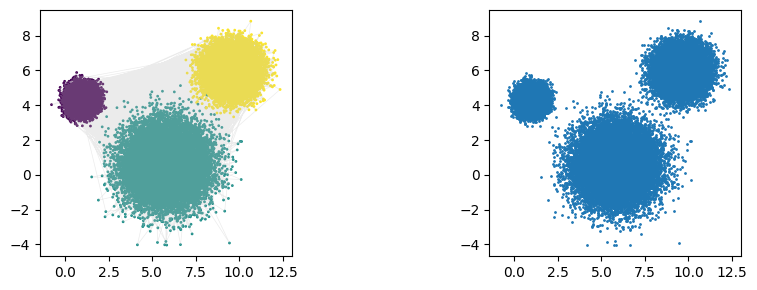

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


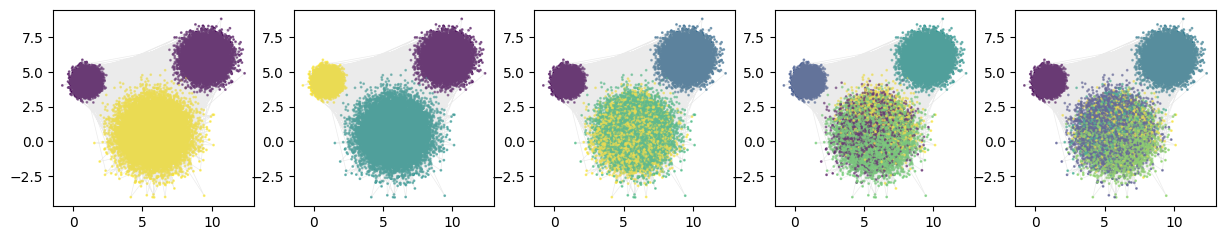

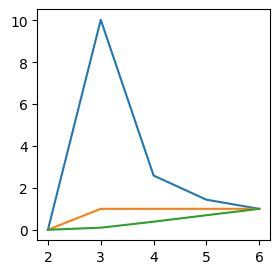

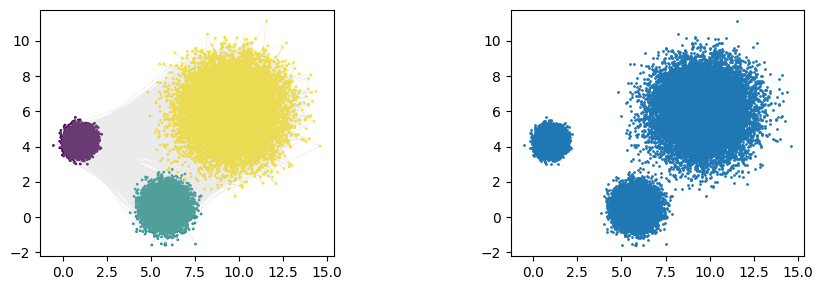

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


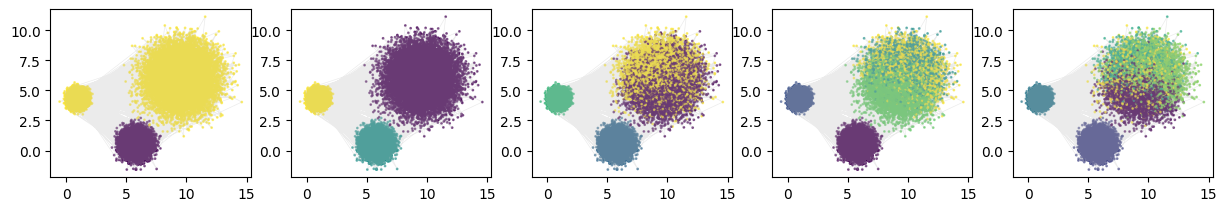

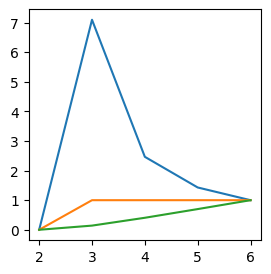

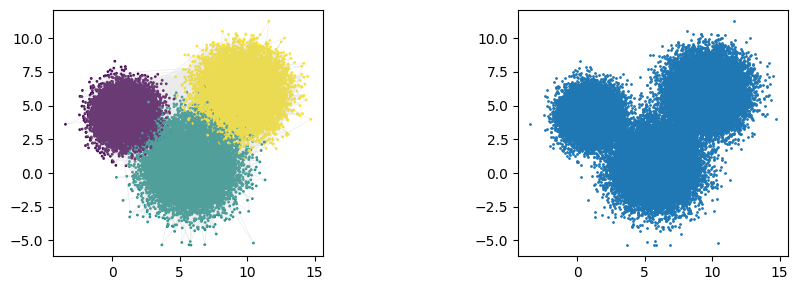

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


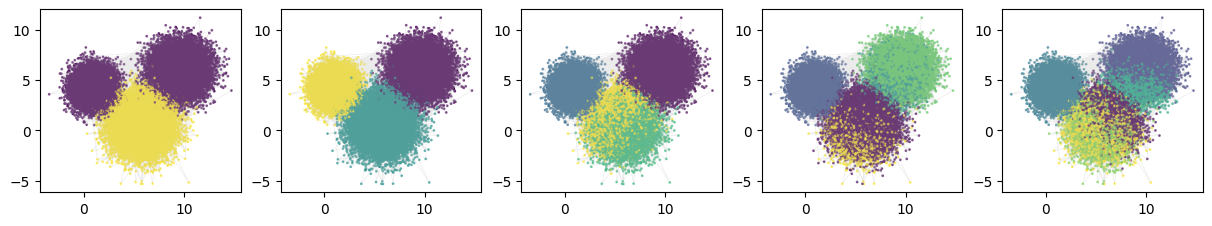

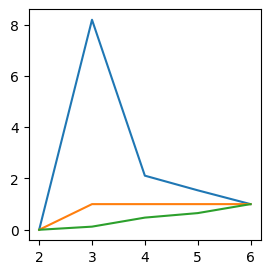

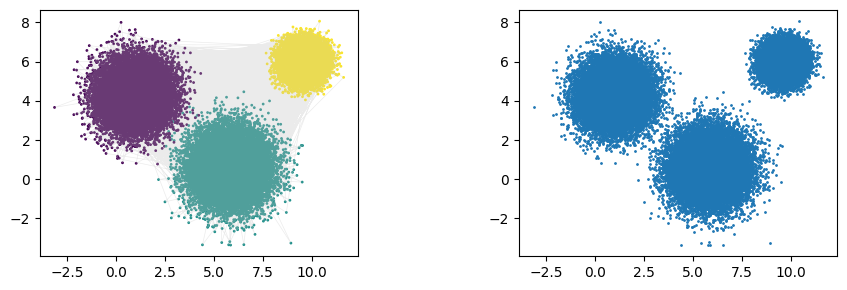

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


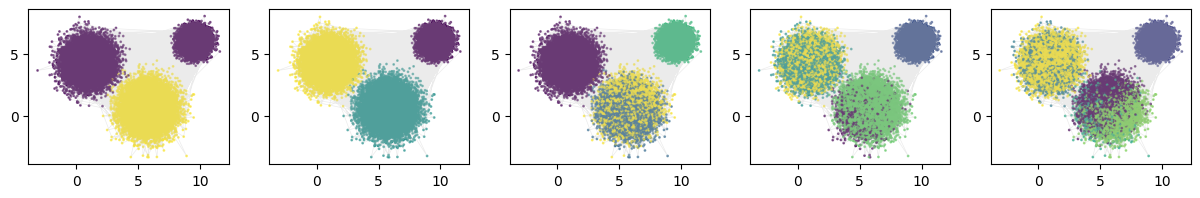

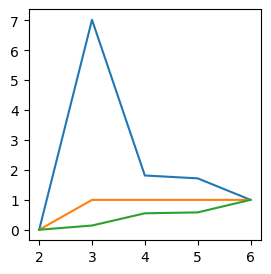

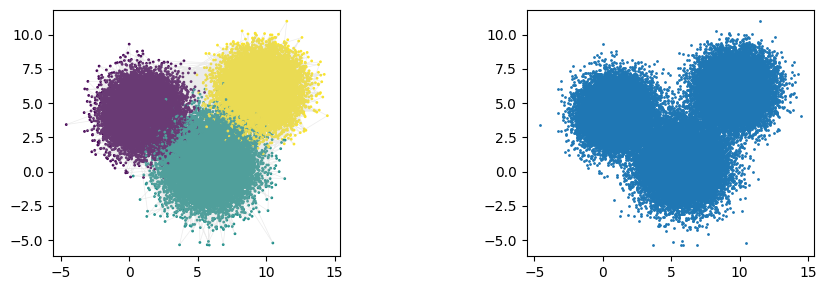

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


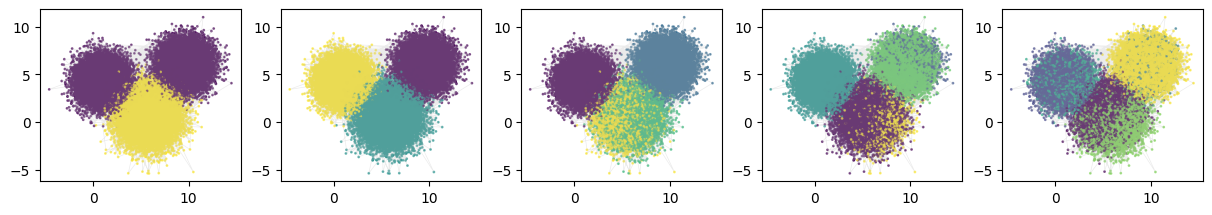

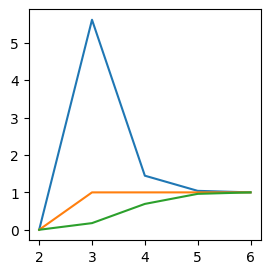

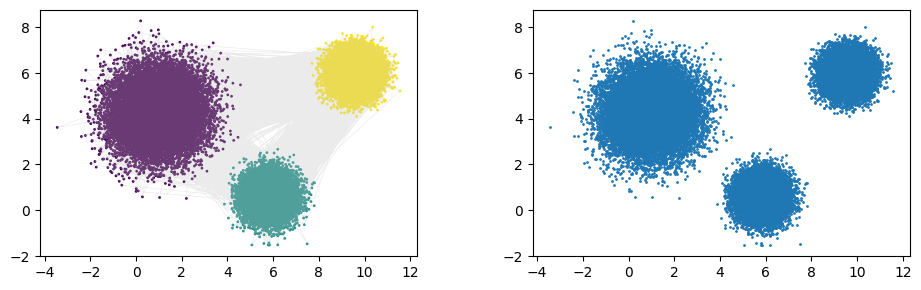

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


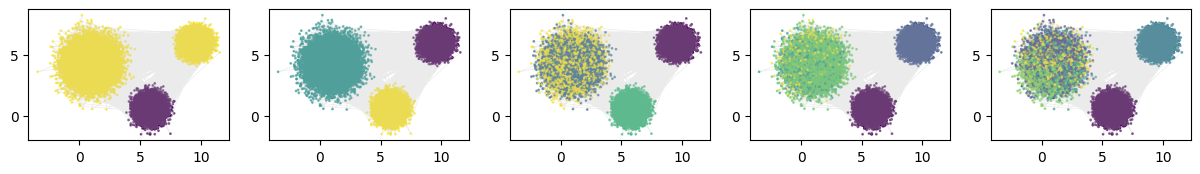

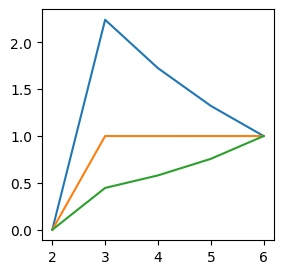

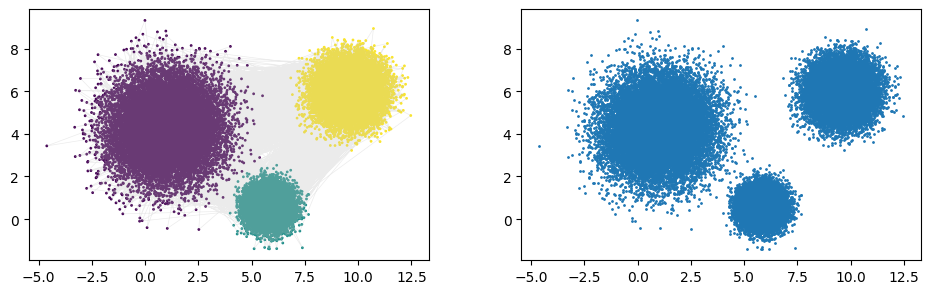

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


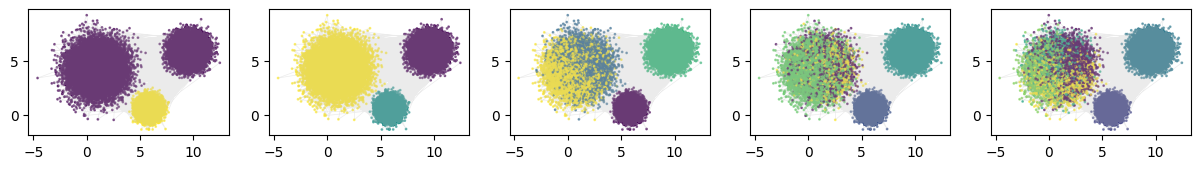

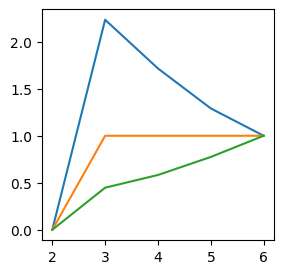

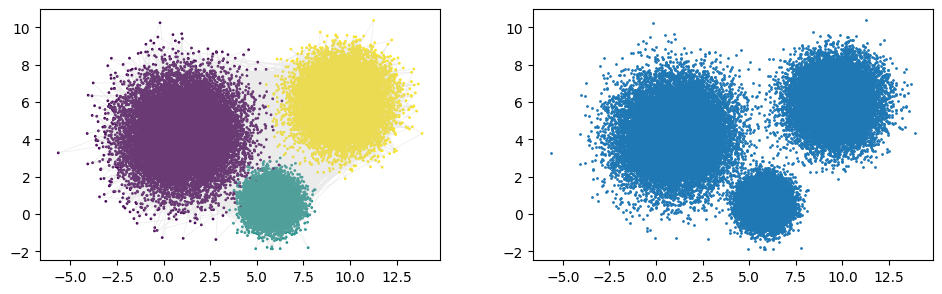

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


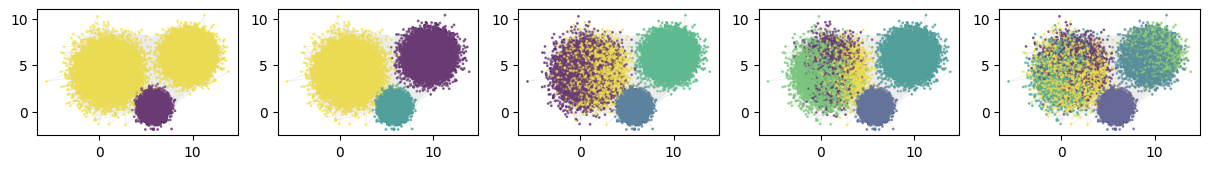

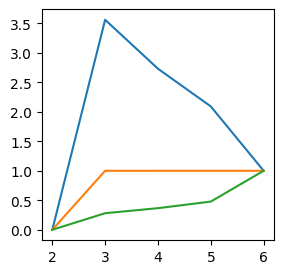

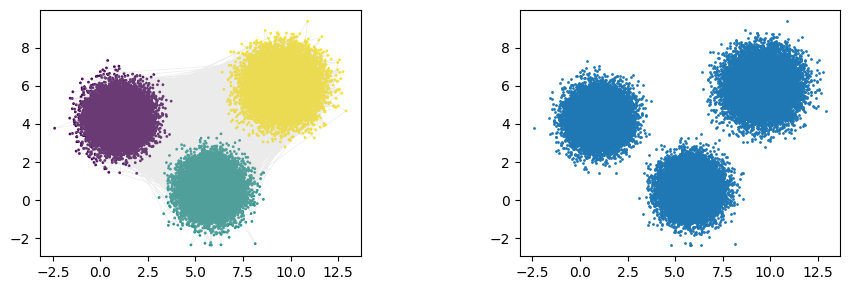

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


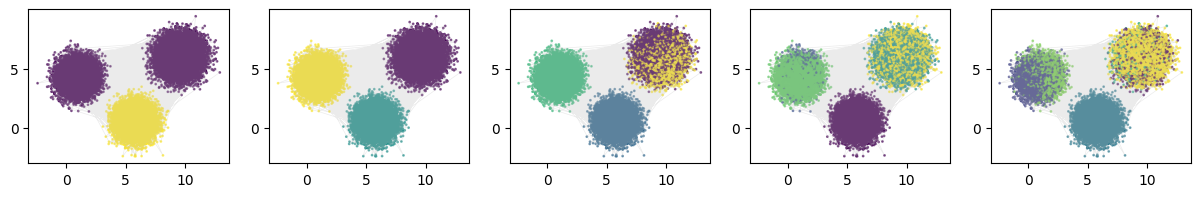

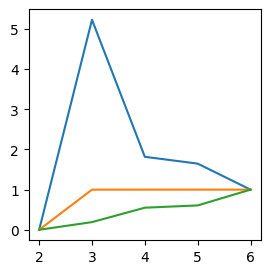

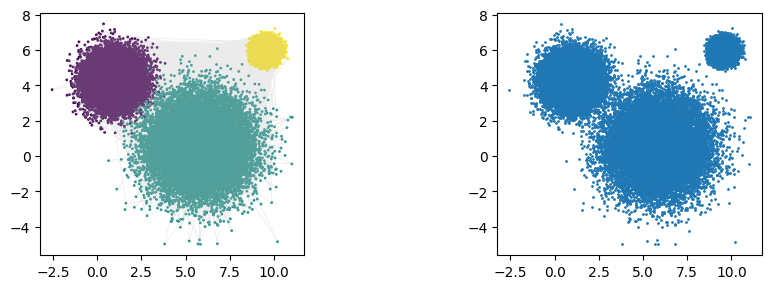

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states


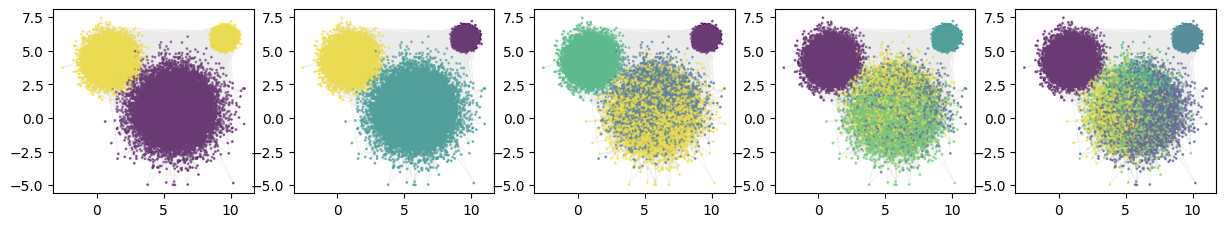

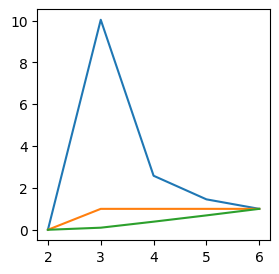

In [4]:
# Set up training parameters
num_train_batches = 5
num_test_batches = 1
num_timesteps = 60000

# Make an HMM and sample data and true underlying states
true_num_states = 3
observations_dim = 10


# add noise? 
# scales = np.random.uniform(0.2, 0.4, true_num_states) ** 2
# perturb_states = np.random.choice(true_num_states, 3, replace = False)
# sign_val = np.random.choice([-1, 1], 3)   

all_num_states = list(range(2, 7))
ll_eig = np.zeros((30, len(all_num_states))) + np.nan
for rep in range(30): 
    hmm, true_params = generate_HMM(true_num_states, observations_dim, num_timesteps, num_train_batches, num_test_batches)


    # Separating data into batches
    train_key = jr.split(jr.PRNGKey(0), 3)
    train_true_states = np.zeros((num_train_batches, num_timesteps)).astype(int)
    train_observations = np.zeros((num_train_batches, num_timesteps,  observations_dim))
    for k in range(num_train_batches):
        train_true_states[k], train_observations[k] = hmm.sample(key = train_key[k], params=true_params, num_timesteps=num_timesteps) 


    # Plot emissions and true_states 
    fig, ax = plt.subplots(1, 2, figsize =(10, 3))

    ax[0].plot(train_observations[0,:, 0], train_observations[0, :, 1], color = 'silver', lw = 0.5,alpha = 0.3)
    ax[0].scatter(train_observations[0,:, 0], train_observations[0, :, 1], c = train_true_states[0], s = 1)
    ax[0].set_aspect(1.0)

    ax[1].plot(train_observations[0,:, 0], train_observations[0, :, 1], ls = 'none', marker = 'o', ms = 1)
    ax[1].set_aspect(1.0)
    plt.tight_layout()
    plt.show()


    # Make a range of Gaussian HMMs

    test_hmms = [GaussianHMM(num_states, observations_dim) for num_states in all_num_states]
    results = []

    fig, ax = plt.subplots(1, len(all_num_states), figsize = (15, 6))
    for i, test_hmm in enumerate(test_hmms):
        print(f"fitting model with {test_hmm.num_states} states")
        results.append(cross_validate_model(test_hmm, jr.PRNGKey(0), ax[i]))

    avg_val_lls, all_val_lls, avg_eig_vals = tuple(zip(*results))
    norm_vals =  min_max(avg_val_lls)/min_max(avg_eig_vals)
    norm_vals[np.where(np.isnan(norm_vals))] = 0
    norm_vals[np.where(np.isinf(norm_vals))] = 1

    plt.figure(figsize = (3, 3))
    plt.plot(np.arange(2, np.max(all_num_states)+1), norm_vals)
    plt.plot(np.arange(2, np.max(all_num_states)+1), min_max(avg_val_lls))
    plt.plot(np.arange(2, np.max(all_num_states)+1), min_max(avg_eig_vals))
    
    ll_eig[rep] = norm_vals

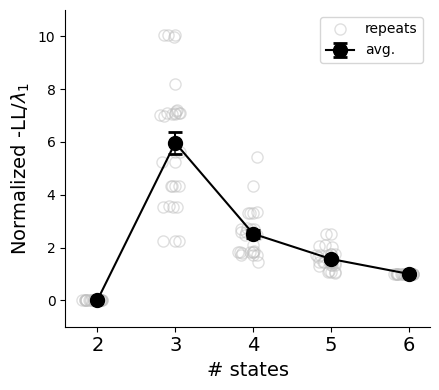

In [5]:
sel_metric = ll_eig
state_range = np.arange(2, 7)
fig, ax = plt.subplots(figsize=(4.5, 4))
mean = np.mean(sel_metric, axis=0)
sem = np.std(sel_metric, axis=0)/np.sqrt(30)
label = 'repeats'
for n in range(30):
    plt.plot(state_range + np.random.rand(1) / 3.5 + 0.1, sel_metric[n, :], marker='o',
             ms=8, color='silver', mfc='none', lw=0.5, alpha=0.5, label=label, ls = 'none')
    label = None  # Set label to None after the first iteration
plt.errorbar(state_range + 0.3, mean, sem, marker='o', color='k', ms=10, capsize=5, capthick=2, label='avg.')
plt.xticks(state_range + 0.3, labels=np.arange(2, 7), fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')
ax.tick_params(bottom=True, left=True, right=False, top=False)
plt.ylabel('Normalized -LL/$\lambda_{1}$', fontsize=14)
plt.ylim(-1, 11)
plt.xticks(fontsize=14)
plt.legend()
# plt.yticks(np.arange(0, 5), fontsize=14)
plt.xlabel('# states', fontsize=14)
plt.tight_layout()

# plt.savefig('HMM_simulation_control_2_v4.png', dpi = 30)
# plt.savefig('HMM_simulation_control_2_v4.pdf')

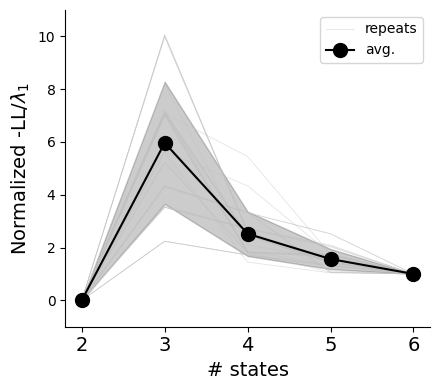

In [6]:
sel_metric = ll_eig
state_range = np.arange(2, 7)
fig, ax = plt.subplots(figsize=(4.5, 4))
mean = np.mean(sel_metric, axis=0)
sem = np.std(sel_metric, axis=0)
label = 'repeats'
for n in range(30):
    plt.plot(state_range + 0.3, sel_metric[n, :],
             ms=8, color='silver', mfc='none', lw=0.5, alpha=0.5, label=label)
    label = None  # Set label to None after the first iteration

plt.errorbar(state_range + 0.3, mean, marker='o', color='k', ms=10, capsize=5, capthick=2, label='avg.')
plt.xticks(state_range + 0.3, labels=np.arange(2, 7), fontsize=12)

plt.fill_between(state_range + 0.3, mean+sem, mean-sem, color = 'k', alpha = 0.2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')
ax.tick_params(bottom=True, left=True, right=False, top=False)
plt.ylabel('Normalized -LL/$\lambda_{1}$', fontsize=14)
plt.ylim(-1, 11)
plt.xticks(fontsize=14)
plt.legend()
# plt.yticks(np.arange(0, 5), fontsize=14)
plt.xlabel('# states', fontsize=14)
plt.tight_layout()


# plt.savefig('HMM_simulation_control_2_v4_1.png', dpi = 30)
# plt.savefig('HMM_simulation_control_2_v4_1.pdf')

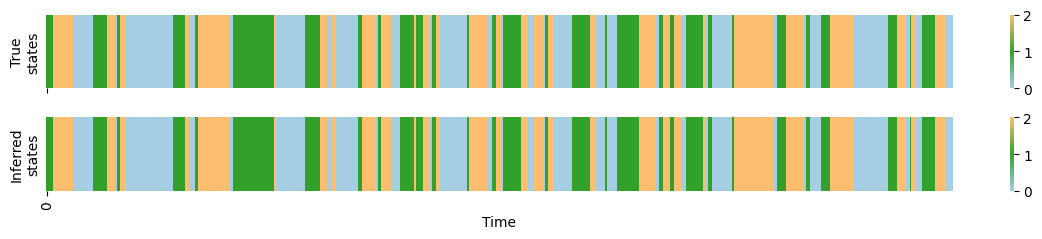

In [7]:
def apply_permutation(arr, permutation):
    # Create a mapping dictionary from the permutation
    mapping = {i: permutation[i] for i in range(len(permutation))}
    
    # Apply the permutation to the array
    return [mapping[value] for value in arr]

import seaborn as sns
import matplotlib.colors as mcolors

best_num_states = state_range[np.argmax(np.nanmean(sel_metric, axis = 0))]
key = jr.PRNGKey(0)
test_hmm = GaussianHMM(best_num_states, observations_dim)
params, props = test_hmm.initialize(key=key, method="kmeans", emissions=train_observations)
params, lps = test_hmm.fit_em(params, props, train_observations[0], num_iters=100)

inferred_states = test_hmm.most_likely_states(params, train_observations[0])
inferred_states = apply_permutation(np.array(inferred_states), np.array(find_permutation(train_true_states[0].astype(int), inferred_states.astype(int))))
inferred_states = np.array(inferred_states)


cmap_original = plt.get_cmap("Paired")
colors = [cmap_original(i) for i in range(0, 7, 3)]

# Create a custom colormap with these colors
cmap_custom = mcolors.LinearSegmentedColormap.from_list("custom_Paired", colors)

# Plot
fig, ax = plt.subplots(2, 1, figsize=(12, 2.5), sharex = True)
sns.heatmap(train_true_states[0].reshape(1, -1), cmap=cmap_custom, yticklabels=False, ax = ax[0])
sns.heatmap(inferred_states.reshape(1, -1), cmap=cmap_custom, yticklabels=False, ax = ax[1])
ax[0].set_ylabel('True\nstates')
ax[1].set_ylabel('Inferred\nstates')
ax[1].set_xlabel('Time')
ax[0].set_xlim(0, 500)
ax[1].set_xlim(0, 500)
plt.tight_layout()
plt.savefig('HMM_simulation_control_2_v4_2.png', dpi = 30)
plt.savefig('HMM_simulation_control_2_v4_2.pdf')

plt.show()


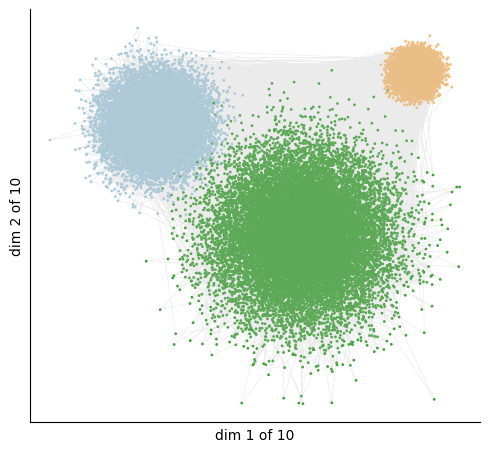

In [10]:
# Plot emissions and true_states 
fig, ax = plt.subplots(figsize =(5, 5))

ax.plot(train_observations[0,:, 0], train_observations[0, :, 1], color = 'silver', lw = 0.5,alpha = 0.3)
ax.scatter(train_observations[0,:, 0], train_observations[0, :, 1], c = train_true_states[0], s = 1, cmap = cmap_custom)
ax.set_aspect(1.0)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('dim 1 of 10')
ax.set_ylabel('dim 2 of 10')
plt.tight_layout()
# plt.savefig('HMM_simulation_control_2_v4_3.png', dpi = 300)
# plt.savefig('HMM_simulation_control_2_v4_3.pdf')
plt.show()